In [43]:
# standard library 
import os
import re
import sys
import math
import zlib
from collections import Counter


# third-party libraries
from typing import List 
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from spacy.tokens import Doc, Token
import nltk
from tqdm.notebook import tqdm
from natsort import natsorted
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


# local module
sys.path.append(os.path.abspath(".."))
from project_config import from_root

In [44]:
# nlp resources
# nltk corpora
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
# spacy model 
nlp = spacy.load("en_core_web_sm")
STOP_WORDS = set(stopwords.words("english"))

In [45]:
PITT_DEMENTIA_PATH = from_root("Pitt", "Dementia", "cookie")
PITT_CONTROL_PATH = from_root("Pitt", "Control", "cookie")
ADRESS_TRAIN_CD_PATH = from_root("ADReSS-IS2020-data", "train", "transcription", "cd")
ADRESS_TRAIN_CC_PATH = from_root("ADReSS-IS2020-data", "train", "transcription", "cc")
ADRESS_TEST_PATH = from_root("ADReSS-IS2020-data", "test", "transcription")

OUT_DATA_DIR = from_root("data")

SAVE_PATHS = {
    "adress_train": from_root("data", "adress_train.tsv"),
    "adress_test": from_root("data", "adress_test.tsv"),
    "pitt_control": from_root("data", "pitt_control.tsv"),
    "pitt_ad": from_root("data", "pitt_ad.tsv")
}

In [46]:
# =============================================================================
# NOTE:
# The following code is used to collect the age of the patients from the 
# transcripts. The age is collected from the @ID line in the transcript files 
# where the age is in the format of "XX;00."
# This step is inteded for reporting and analysis purposes only, thus you can 
# skip this step. 
# =============================================================================
def collect_exact_educated_guesses(base_dir: str) -> pd.DataFrame:
    results = []
    cha_files = []
    for root, _, files in os.walk(base_dir):
        cha_files.extend([
            os.path.join(root, file)
            for file in files if file.endswith(".cha")
        ])

    for file_path in tqdm(cha_files, desc=f"Scanning {os.path.basename(base_dir)}"):
        file_id = os.path.splitext(os.path.basename(file_path))[0]
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                for line in f:
                    if line.startswith("@ID") and "|PAR|" in line:
                        parts = line.strip().split("|")
                        if len(parts) > 4:
                            raw_age = parts[3].strip()
                            if re.fullmatch(r"\d{2};00\.", raw_age):
                                results.append({
                                    "ID": file_id,
                                    "raw_age": raw_age
                                })
                        break  # only need to inspect one @ID line
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return pd.DataFrame(results)

def save_sorted_educated_guesses(df: pd.DataFrame, out_path: str, label: str) -> None:
    df = df.set_index("ID")
    df = df.loc[natsorted(df.index)].reset_index()
    df.to_csv(out_path, sep="\t", index=False)
    print(f"Found {len(df)} educated guess age entries ({label})")

df_ad = collect_exact_educated_guesses(PITT_DEMENTIA_PATH)
df_control = collect_exact_educated_guesses(PITT_CONTROL_PATH)

save_sorted_educated_guesses(
    df_ad,
    os.path.join(OUT_DATA_DIR, "pitt_educated_guess_ages_ad.tsv"),
    label="AD"
)

save_sorted_educated_guesses(
    df_control,
    os.path.join(OUT_DATA_DIR, "pitt_educated_guess_ages_control.tsv"),
    label="Control"
)

Scanning cookie:   0%|          | 0/306 [00:00<?, ?it/s]

Scanning cookie:   0%|          | 0/243 [00:00<?, ?it/s]

Found 30 educated guess age entries (AD)
Found 60 educated guess age entries (Control)


In [47]:
# =============================================================================
# Title: ADReSS Challenge Analysis Notebook
# Author: Thomas Searle
# Date: 2020
# Code version: N/A (not versioned)
# Type: Source code (Jupyter Notebook)
# Availability: https://github.com/tomolopolis/ADReSS_Challenge/blob/master/Analysis.ipynb
# Note: The following code was inspired by the above source.
# =============================================================================

def clean_cha_line(text: str, roberta: bool = False) -> str:
    # remove timestamps (e.g., 00000432_00000550)
    text = re.sub(r'.*?', '', text)
    # remove annotations like [//], [*], etc.
    text = re.sub(r'\[.*?\]', '', text)
    # remove non-verbal info in parentheses
    text = re.sub(r'\(.*?\)', '', text)
    if roberta:
        # remove all non-alphanumeric characters except whitespace
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    else:
        # remove all non-alphanumeric characters but keep punctuation like ., !, ?
        text = re.sub(r'[^a-zA-Z0-9\s\.\!\?]', '', text)
    # normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
            
    return text

def remove_duplicate_words(text: str) -> str:
    # used code from: https://stackoverflow.com/questions/17238587/python-regular-expression-to-remove-repeated-words
    # remove consecutive duplicate words (e.g., "the the", "from from")
    cleaned_text = re.sub(r'\b(\w+)(?:\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)
    return cleaned_text


def extract_transcript_only(
    file_path: str, 
    label: int | None = None, 
    dataset: str | None = None,
    remove_duplicates: bool = False
) -> dict:
    file_name = os.path.basename(file_path)
    file_id = file_name.split(".cha")[0]

    record = {"ID": file_id, "dataset": dataset, "label": label}
    transcript = []
    disfluency_count = 0
    pause_count = 0
    utterance_count = 0

    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()

            # extract metadata
            if line.startswith("@ID"):
                parts = line.split("|")
                if len(parts) > 4 and parts[2].strip() == "PAR":
                    if parts[4].strip():
                        record["gender"] = parts[4].strip()[0]
                    else:
                        record["gender"] = None
                    raw_age = parts[3].strip()
                    try:
                        if raw_age:
                            # extract digits before semicolon
                            fixed_age = int(raw_age.split(";")[0])
                            record["age"] = fixed_age
                    except:
                        record["age"] = None
                    try:
                        if len(parts) > 8 and parts[8].strip():
                            # print("MMSE score found:", parts[8].strip())
                            record["mmse"] = float(parts[8].strip())
                    except:
                        record["mmse"] = None

            # participant lines
            if line.startswith("*PAR:"):
                utterance_count += 1
                raw_text = line.split(":", 1)[1].strip()

                #  if participant has more than one line of text continue reading
                i += 1
                while i < len(lines):
                    next_line = lines[i].strip()
                    if next_line.startswith("*") or next_line.startswith("@") or next_line.startswith("%"):
                        break  # not a continuation
                    raw_text += " " + next_line
                    i += 1
                #  count disfluency and pause features 
                for tag in ["[//]", "[/]", "[/-]", "[*]", "[+...", "+//.", "[+"]:
                    disfluency_count += raw_text.count(tag)
                pause_count += len(re.findall(r"\(\.\)", raw_text))           # short pause
                pause_count += len(re.findall(r"\(\.\.\)", raw_text))         # medium pause
                pause_count += len(re.findall(r"\(\.\.\.\)", raw_text))       # long pause
                pause_count += len(re.findall(r"\(\d+\.\d+\)", raw_text))     # timed pause

                cleaned_text = clean_cha_line(raw_text, roberta=remove_duplicates)
                if remove_duplicates: # for RoBERTa models
                    cleaned_text = remove_duplicate_words(cleaned_text)
                transcript.append(cleaned_text)

                continue 
            i += 1

    full_text = " ".join(transcript)
    record["transcription"] = full_text
    record["disfluencies"] = disfluency_count
    record["pause_count"] = pause_count
    record["utterance_count"] = utterance_count
    return record


def collect_data_from_directory(
    base_dir: str, 
    label: int | None, 
    dataset_tag: str,
    remove_duplicates: bool = False
) -> list[dict]:
    all_records = []
    cha_files = []
    for root, _, files in os.walk(base_dir):
        cha_files.extend([
            os.path.join(root, file)
            for file in files if file.endswith(".cha")
        ])

    for file_path in tqdm(cha_files, desc=f"Processing {dataset_tag}"):
        try:
            data = extract_transcript_only(file_path, label=label, dataset=dataset_tag, remove_duplicates=remove_duplicates)
            all_records.append(data)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return all_records


# ADReSS datasets (RF = keep duplicates, RoBERTa = remove them)
adress_train_cd = collect_data_from_directory(ADRESS_TRAIN_CD_PATH, 1, "ADReSS-train", remove_duplicates=False)
adress_train_cc = collect_data_from_directory(ADRESS_TRAIN_CC_PATH, 0, "ADReSS-train", remove_duplicates=False)
adress_train_cd_roberta = collect_data_from_directory(ADRESS_TRAIN_CD_PATH, 1, "ADReSS-train", remove_duplicates=True)
adress_train_cc_roberta = collect_data_from_directory(ADRESS_TRAIN_CC_PATH, 0, "ADReSS-train", remove_duplicates=True)

adress_test_rf = collect_data_from_directory(ADRESS_TEST_PATH, None, "ADReSS-test", remove_duplicates=False)
adress_test_roberta = collect_data_from_directory(ADRESS_TEST_PATH, None, "ADReSS-test", remove_duplicates=True)

# Pitt datasets (do the same)
pitt_control_rf = collect_data_from_directory(PITT_CONTROL_PATH, 0, "Pitt-Control", remove_duplicates=False)
pitt_dementia_rf = collect_data_from_directory(PITT_DEMENTIA_PATH, 1, "Pitt-Dementia", remove_duplicates=False)
pitt_control_roberta = collect_data_from_directory(PITT_CONTROL_PATH, 0, "Pitt-Control", remove_duplicates=True)
pitt_dementia_roberta = collect_data_from_directory(PITT_DEMENTIA_PATH, 1, "Pitt-Dementia", remove_duplicates=True)

# combine and save datasets
df_adress_train_rf = pd.DataFrame(adress_train_cd + adress_train_cc)
df_adress_train_roberta = pd.DataFrame(adress_train_cd_roberta + adress_train_cc_roberta)

df_adress_test = pd.DataFrame(adress_test_rf)
df_adress_test_roberta = pd.DataFrame(adress_test_roberta)

df_pitt_control = pd.DataFrame(pitt_control_rf)
df_pitt_control_roberta = pd.DataFrame(pitt_control_roberta)

df_pitt_ad = pd.DataFrame(pitt_dementia_rf)
df_pitt_ad_roberta = pd.DataFrame(pitt_dementia_roberta)

#  for RF
df_adress_train_rf.to_csv(SAVE_PATHS["adress_train"], sep="\t", index=False)
df_adress_test.to_csv(SAVE_PATHS["adress_test"], sep="\t", index=False)
df_pitt_control.to_csv(SAVE_PATHS["pitt_control"], sep="\t", index=False)
df_pitt_ad.to_csv(SAVE_PATHS["pitt_ad"], sep="\t", index=False)

# for RoBERTa -> drop duplicates and the features (only needs raw text)
df_adress_train_roberta.drop(columns=["disfluencies", "pause_count", "utterance_count"], errors="ignore")\
    .to_csv(from_root("data", "adress_train_roberta.tsv"), sep="\t", index=False)

df_adress_test_roberta.drop(columns=["disfluencies", "pause_count", "utterance_count"], errors="ignore")\
    .to_csv(from_root("data", "adress_test_roberta.tsv"), sep="\t", index=False)

df_pitt_control_roberta.drop(columns=["disfluencies", "pause_count", "utterance_count"], errors="ignore")\
    .to_csv(from_root("data", "pitt_control_roberta.tsv"), sep="\t", index=False)

df_pitt_ad_roberta.drop(columns=["disfluencies", "pause_count", "utterance_count"], errors="ignore")\
    .to_csv(from_root("data", "pitt_ad_roberta.tsv"), sep="\t", index=False)

Processing ADReSS-train:   0%|          | 0/54 [00:00<?, ?it/s]

Processing ADReSS-train:   0%|          | 0/54 [00:00<?, ?it/s]

Processing ADReSS-train:   0%|          | 0/54 [00:00<?, ?it/s]

Processing ADReSS-train:   0%|          | 0/54 [00:00<?, ?it/s]

Processing ADReSS-test:   0%|          | 0/48 [00:00<?, ?it/s]

Processing ADReSS-test:   0%|          | 0/48 [00:00<?, ?it/s]

Processing Pitt-Control:   0%|          | 0/243 [00:00<?, ?it/s]

Processing Pitt-Dementia:   0%|          | 0/306 [00:00<?, ?it/s]

Processing Pitt-Control:   0%|          | 0/243 [00:00<?, ?it/s]

Processing Pitt-Dementia:   0%|          | 0/306 [00:00<?, ?it/s]

In [48]:
# =============================================================================
# NOTE:
# The files `manual_age_fix_pitt_ad.tsv` and `manual_age_fix_pitt_control.tsv`
# were manually created based on the demographic spreadsheet available from 
# the Pitt Corpus (TalkBank). These files contain corrected age values for 
# participants where the transcript data was missing.
#
# These files are not required to run the pipeline. You may skip this cell
# if you do not have these files or prefer not to apply manual age corrections.
# =============================================================================

MANUAL_AGE_AD_PATH = from_root("data", "raw", "manual_age_fix_pitt_ad.tsv")
MANUAL_AGE_CONTROL_PATH = from_root("data", "raw", "manual_age_fix_pitt_control.tsv")
PITT_AD_SAVE_PATH = from_root("data", "pitt_ad.tsv")
PITT_CONTROL_SAVE_PATH = from_root("data", "pitt_control.tsv")


def apply_manual_age_fix(
    df: pd.DataFrame, 
    manual_path: str, 
    save_path: str
) -> pd.DataFrame:
    """
    Changes age values in df with manually corrected ones from official spreadsheet.
    """
    manual_ages = pd.read_csv(manual_path, sep="\t")
    df = df.merge(manual_ages, on="ID", how="left", suffixes=("", "_manual"))
    df.loc[df["age_manual"].notna(), "age"] = df["age_manual"]
    df.drop(columns="age_manual", inplace=True)
    df.to_csv(save_path, sep="\t", index=False)
    return df

df_pitt_ad = apply_manual_age_fix(df_pitt_ad, MANUAL_AGE_AD_PATH, PITT_AD_SAVE_PATH)
df_pitt_control = apply_manual_age_fix(df_pitt_control, MANUAL_AGE_CONTROL_PATH, PITT_CONTROL_SAVE_PATH)

In [49]:
IU_KEYWORDS = ["cookie", "girl", "boy", "mother", "chair", "jar", "sink", "kitchen",
               "water", "hand", "cupboard", "stool", "plate", "overflowing"]

FIRST_PERSON_PRONOUNS = {"i", "me", "my", "mine", "we", "us", "our", "ours"}
THIRD_PERSON_PRONOUNS = {"he", "him", "his", "she", "her", "hers", "they", "them", "their", "theirs"}


def type_token_ratio(tokens : List[str]) -> float:
    # calculates the ratio of unique words to total words (lexical diversity)
    types = set(tokens)
    if tokens: 
        return len(types) / len(tokens)
    else: 
        return 0


def honore_statistic(tokens : List[str]) -> float:
    # calculates lexical richness, giving more weight to words appearing once
    N = len(tokens)
    V = len(set(tokens))
    if V == 0:
        return 0
    V1 = 0 # count of unique words (only appear once)
    word_counts = Counter(tokens)
    for word, freq in word_counts.items():
        if freq == 1:
            V1 += 1
    if V > 0 and V1 < V:
        return 100 * math.log(N) / (1 - V1 / V)
    else:
        return 0


def idea_density(tokens : List[str]) -> float:
    # estimates the density of content words (nouns, verbs, adjectives, adverbs)
    # how much info is packed into the text -> proportion of content words to total tokens
    content_pos = {"NOUN", "VERB", "ADJ", "ADV"}
    if not tokens:
        return 0
    doc = nlp(" ".join(tokens))
    count = 0
    for token in doc:
        if token.pos_ in content_pos:
            count += 1
    return count/len(tokens)


def compression_ratio(text : str) -> float:
    # measures text complexity by calculating the ratio of compressed to uncompressed text size
    raw = text.encode("utf-8")
    compressed = zlib.compress(raw)
    return len(compressed) / len(raw) if raw else 0


def count_iu_keywords(tokens : List[str]) -> int:
    # counts the number of IU keywords in the text
    count = 0
    for token in tokens:
        if token.lower() in IU_KEYWORDS:
            count += 1
    return count


def moving_average_ttr(tokens: List[str], window_size: int = 50) -> float:
    # MATTR Calculation (Moving-Average TTR)
    if len(tokens) < window_size:
        return len(set(tokens)) / len(tokens) if tokens else 0
    ttr_values = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        ttr_values.append(len(set(window)) / window_size)
    return np.mean(ttr_values)


def count_cfg_rules(doc : Doc) -> Counter:
    # count CFG Production Rules
    production_counter = Counter()
    for sent in doc.sents:
        for token in sent:
            rule = f"{token.pos_} -> {' '.join(child.pos_ for child in token.children)}"
            production_counter[rule] += 1
    return production_counter


def compute_repetition_score(sentences: List[str]) -> float:
    # measure Repetition via Cosine Distance
    if len(sentences) < 2:
        return 0
    vectorizer = CountVectorizer().fit(sentences)
    vectors = vectorizer.transform(sentences).toarray()
    similarities = []
    for i in range(len(vectors)):
        for j in range(i+1, len(vectors)):
            norm_i = np.linalg.norm(vectors[i])
            norm_j = np.linalg.norm(vectors[j])
            if norm_i != 0 and norm_j != 0:
                sim = np.dot(vectors[i], vectors[j]) / (norm_i * norm_j)
                similarities.append(sim)
    if similarities:
        return np.mean(similarities)
    return 0


def brunet_index(tokens: List[str]) -> float:
    # Brunet Index -> measures lexical richness
    n = len(tokens)
    v = len(set(tokens))
    if n > 0:
        return n ** (v ** -0.165)
    return 0


def named_entity_count(doc : Doc) -> int:
    entity_count = 0
    for ent in doc.ents: 
        entity_count += 1
    return entity_count


def noun_verb_ratio(noun_ratio: float, verb_ratio: float) -> float:
    if verb_ratio != 0:
        return noun_ratio / verb_ratio
    return 0


def get_tree_depth(token : Token) -> int:
    children = list(token.children)
    if not children:
        return 1
    depths = []
    for child in children:
        depths.append(get_tree_depth(child))
    return 1 + max(depths) 


def extract_linguistic_features(row : pd.Series) -> pd.Series:
    text = row["transcription"]
    doc = nlp(text)
    tokens = []
    # lemmatized tokens (for all lexical metrics, e.g., running, ran, run -> run)
    for token in doc:
        if token.is_alpha:
            tokens.append(token.lemma_.lower())
    
    mattr_value = moving_average_ttr(tokens)
    cfg_counter = count_cfg_rules(doc)
    repetition_score = compute_repetition_score([sent.text for sent in doc.sents])
    brunet = brunet_index(tokens)
    named_ents = named_entity_count(doc)

    # POS tagging -> tags like grammatical roles (noun, verb, etc.) 
    pos_counts = Counter()
    for token in doc:
        pos_counts[token.pos_] += 1

    num_words = len(tokens)  
    sents = list(doc.sents) # sentence segmentation
    num_sents = len(sents) # num of sentences
    num_cius = count_iu_keywords(tokens) 

    # prononun counts
    first_pron_count = 0
    third_pron_count = 0 
    stopword_count = 0
    for t in tokens:
        if t in FIRST_PERSON_PRONOUNS:
            first_pron_count += 1
        if t in THIRD_PERSON_PRONOUNS:
            third_pron_count += 1
        if t in STOP_WORDS:
            stopword_count += 1
    
    # POS ratios
    pronoun_ratio = pos_counts.get("PRON", 0) / num_words if num_words else 0
    first_person_ratio = first_pron_count / num_words if num_words else 0
    third_person_ratio = third_pron_count / num_words if num_words else 0
    stopword_ratio = stopword_count / num_words if num_words else 0
    noun_ratio = pos_counts.get("NOUN", 0) / num_words if num_words else 0
    verb_ratio = pos_counts.get("VERB", 0) / num_words if num_words else 0
    prep_ratio = pos_counts.get("ADP", 0) / num_words if num_words else 0
    adv_ratio = pos_counts.get("ADV", 0) / num_words if num_words else 0
    auxiliary_ratio = pos_counts.get("AUX", 0) / num_words if num_words else 0

    noun_verb = noun_verb_ratio(noun_ratio, verb_ratio)
    mean_sentence_length = num_words / num_sents if num_sents else 0

    # parse tree depth
    sentence_tree_depths = []
    for sent in sents:
        sentence_tree_depths.append(get_tree_depth(sent.root))
    parse_tree_depth = max(sentence_tree_depths) if sentence_tree_depths else 0

    # clause count
    clause_labels = {"ccomp", "advcl", "relcl"}
    clause_count = 0
    for token in doc:
        if token.dep_ in clause_labels:
            clause_count += 1
    clauses_per_sentence = clause_count / num_sents if num_sents else 0
    
    # content density --> proportion of content words (nouns, verbs, adjectives, adverbs) to total tokens
    content_density_sum = 0
    for tag in ["NOUN", "VERB", "ADJ", "ADV"]:
        content_density_sum += pos_counts.get(tag, 0)
    content_density = content_density_sum / num_words if num_words else 0

    features = {
        "word_count": num_words,
        "unique_words": len(set(tokens)),
        "type_token_ratio": type_token_ratio(tokens),
        "honore_statistic": honore_statistic(tokens),
        "idea_density": idea_density(tokens),
        "compression_ratio": compression_ratio(text),
        "content_density": content_density,
        "pronoun_ratio": pronoun_ratio,
        "first_person_ratio": first_person_ratio,
        "third_person_ratio": third_person_ratio,
        "stopword_ratio": stopword_ratio,
        "noun_ratio": noun_ratio,
        "verb_ratio": verb_ratio,
        "prep_ratio": prep_ratio,
        "adv_ratio": adv_ratio,
        "auxiliary_ratio": auxiliary_ratio,
        "mean_sentence_length": mean_sentence_length,
        "num_sentences": num_sents,
        "IU_count": num_cius,
        "IU_density": num_cius / num_words if num_words else 0,
        "parse_tree_depth": parse_tree_depth,
        "clauses_per_sentence": clauses_per_sentence,
        "disfluency_count": row.get("disfluencies", 0),
        "pause_count": row.get("pause_count", 0),
        "utterance_count": row.get("utterance_count", 0),
        "mattr": mattr_value,
        "repetition_score": repetition_score,
        "cfg_np_to_nn": cfg_counter.get("NOUN -> NOUN", 0),
        "cfg_np_to_det_noun": cfg_counter.get("NOUN -> DET NOUN", 0),
        "brunet_index": brunet,
        "named_entity_count": named_ents,
        "noun_verb_ratio": noun_verb,
    }
    return pd.Series(features)

In [50]:
tqdm.pandas()

INPUT_FILES = {
    "adress_train": from_root("data", "adress_train.tsv"),
    "adress_test": from_root("data", "adress_test.tsv"),
    "pitt_control": from_root("data", "pitt_control.tsv"),
    "pitt_ad": from_root("data", "pitt_ad.tsv"),
}

def process_and_save(input_path: str, output_path: str) -> None:
    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return 
    
    df = pd.read_csv(input_path, sep="\t")
    features_df = df.progress_apply(extract_linguistic_features, axis=1)
    metadata_cols = ["ID", "label", "gender", "age"]
    available_cols = []
    for col in metadata_cols: 
        if col in df.columns: 
            available_cols.append(col)

    final_df = pd.concat([df[available_cols], features_df], axis=1)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)  
    final_df.to_csv(output_path, sep="\t", index=False)


for name, input_path in INPUT_FILES.items():
    print(f"Processing dataset: {name.replace('_', ' ').title()}")
    filename = os.path.basename(input_path).replace(".tsv", "_features.tsv")
    output_path = from_root("data", "features", filename)
    process_and_save(input_path, output_path)

Processing dataset: Adress Train


  0%|          | 0/108 [00:00<?, ?it/s]

Processing dataset: Adress Test


  0%|          | 0/48 [00:00<?, ?it/s]

Processing dataset: Pitt Control


  0%|          | 0/243 [00:00<?, ?it/s]

Processing dataset: Pitt Ad


  0%|          | 0/306 [00:00<?, ?it/s]

**The part below is for the thesis paper not needed for the pipeline**

Numeric columns: ['label', 'age', 'word_count', 'unique_words', 'type_token_ratio', 'honore_statistic', 'idea_density', 'compression_ratio', 'content_density', 'pronoun_ratio', 'first_person_ratio', 'third_person_ratio', 'stopword_ratio', 'noun_ratio', 'verb_ratio', 'prep_ratio', 'adv_ratio', 'auxiliary_ratio', 'mean_sentence_length', 'num_sentences', 'IU_count', 'IU_density', 'parse_tree_depth', 'clauses_per_sentence', 'disfluency_count', 'pause_count', 'utterance_count', 'mattr', 'repetition_score', 'cfg_np_to_nn', 'cfg_np_to_det_noun', 'brunet_index', 'named_entity_count', 'noun_verb_ratio']
      IU_density                     type_token_ratio                      \
            mean       std    median             mean       std    median   
label                                                                       
0       0.119730  0.035808  0.115074         0.586401  0.099737  0.574342   
1       0.097872  0.051844  0.092515         0.572017  0.118254  0.580323   

      repeti

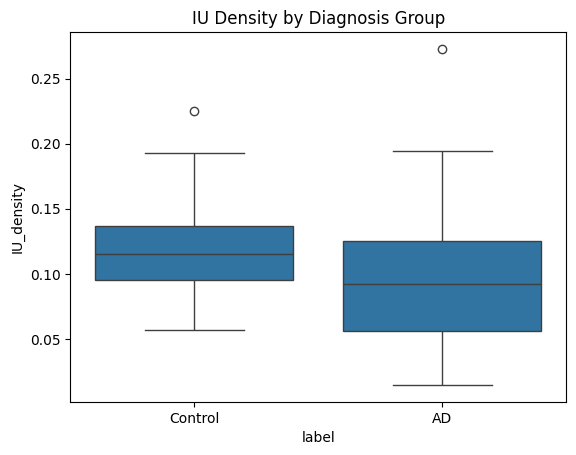

In [51]:
df = pd.read_csv(from_root("data", "features", "adress_train_features.tsv"), sep="\t")

numeric_cols = df.select_dtypes(include='number').columns
df_numeric = df[numeric_cols]

print("Numeric columns:", df_numeric.columns.tolist())

group_stats = df_numeric.groupby("label").agg(["mean", "std", "median"])
print(group_stats[["IU_density", "type_token_ratio", "repetition_score", "brunet_index"]])

ad = df[df["label"] == 1]["IU_density"]
control = df[df["label"] == 0]["IU_density"]

t_stat, p = ttest_ind(ad, control, equal_var=False)
print(f"IU_density t-test: t={t_stat:.3f}, p={p:.4f}")

sns.boxplot(data=df, x="label", y="IU_density")
plt.xticks([0, 1], ["Control", "AD"])
plt.title("IU Density by Diagnosis Group")
plt.show()

In [53]:
correlations = df.corr(numeric_only=True)["label"].sort_values(ascending=False)
print(correlations)

label                   1.000000
adv_ratio               0.403065
pronoun_ratio           0.285975
disfluency_count        0.209101
pause_count             0.193129
first_person_ratio      0.174741
compression_ratio       0.131539
third_person_ratio      0.126588
stopword_ratio          0.123894
noun_verb_ratio         0.066652
age                     0.031347
num_sentences           0.017286
utterance_count         0.014554
cfg_np_to_nn           -0.024427
brunet_index           -0.026384
clauses_per_sentence   -0.033364
named_entity_count     -0.050365
type_token_ratio       -0.066221
word_count             -0.066332
idea_density           -0.073763
content_density        -0.093702
cfg_np_to_det_noun     -0.123508
verb_ratio             -0.152289
mean_sentence_length   -0.153531
parse_tree_depth       -0.161076
mattr                  -0.161750
noun_ratio             -0.190855
repetition_score       -0.201769
unique_words           -0.204298
IU_density             -0.240346
honore_sta

In [54]:
df = pd.read_csv(from_root("data", "features", "adress_train_features.tsv"), sep="\t")
numeric_cols = df.select_dtypes(include='number').columns.drop(['label', 'age'], errors='ignore')
# print("Numeric columns:", numeric_cols.tolist())
results = []

# comparing AD (1) w/ Control (0) for each feature -> linguistic features section thesis
for col in numeric_cols:
    ad_vals = df[df["label"] == 1][col].dropna()
    ctrl_vals = df[df["label"] == 0][col].dropna()

    ad_mean = ad_vals.mean()
    ctrl_mean = ctrl_vals.mean()
    ad_std = ad_vals.std()
    ctrl_std = ctrl_vals.std()
    t_stat, p_val = ttest_ind(ad_vals, ctrl_vals, equal_var=False)

    results.append({
        "feature": col,
        "control_mean": ctrl_mean,
        "ad_mean": ad_mean,
        "t_stat": t_stat,
        "p_value": p_val
    })

results_df = pd.DataFrame(results)
results_df["abs_t"] = results_df["t_stat"].abs()
results_df = results_df.sort_values(by="p_value")
print(results_df[["feature", "control_mean", "ad_mean", "t_stat", "p_value"]])

                 feature  control_mean      ad_mean    t_stat   p_value
14             adv_ratio      0.025123     0.046332  4.534454  0.000019
18              IU_count     12.759259     8.907407 -4.001145  0.000117
15       auxiliary_ratio      0.085455     0.064970 -3.273782  0.001453
7          pronoun_ratio      0.114284     0.142251  3.072618  0.002726
13            prep_ratio      0.090165     0.074676 -2.802253  0.006057
3       honore_statistic   1670.128886  1408.417423 -2.711896  0.007811
19            IU_density      0.119730     0.097872 -2.549234  0.012411
22      disfluency_count      7.166667    11.314815  2.201495  0.031176
1           unique_words     62.870370    53.962963 -2.148692  0.033959
26      repetition_score      0.132664     0.110213 -2.120957  0.036400
23           pause_count      0.888889     1.537037  2.026533  0.045921
11            noun_ratio      0.215161     0.192652 -2.001769  0.048416
8     first_person_ratio      0.018105     0.024560  1.827179  0

In [55]:
# pitt datasets
df_control = pd.read_csv(from_root("data", "features", "pitt_control_features.tsv"), sep="\t")
df_ad = pd.read_csv(from_root("data", "features", "pitt_ad_features.tsv"), sep="\t")
df_pitt = pd.concat([df_control, df_ad], ignore_index=True)

print(df_pitt['label'].value_counts())

label
1    306
0    243
Name: count, dtype: int64


In [56]:
numeric_cols = df_pitt.select_dtypes(include='number').columns.drop(['label', 'age'], errors='ignore')

results = []

for col in numeric_cols:
    ad_vals = df_pitt[df_pitt["label"] == 1][col].dropna()
    ctrl_vals = df_pitt[df_pitt["label"] == 0][col].dropna()

    ad_mean = ad_vals.mean()
    ctrl_mean = ctrl_vals.mean()
    t_stat, p_val = ttest_ind(ad_vals, ctrl_vals, equal_var=False)

    results.append({
        "feature": col,
        "control_mean": ctrl_mean,
        "ad_mean": ad_mean,
        "t_stat": t_stat,
        "p_value": p_val
    })

results_df = pd.DataFrame(results)
results_df["abs_t"] = results_df["t_stat"].abs()
results_df = results_df.sort_values(by="p_value")
print(results_df[["feature", "control_mean", "ad_mean", "t_stat", "p_value"]])

                 feature  control_mean      ad_mean    t_stat       p_value
14             adv_ratio      0.023847     0.037851  6.977150  8.980402e-12
15       auxiliary_ratio      0.083060     0.065735 -6.807358  2.704571e-11
18              IU_count     12.362140     9.875817 -6.037921  2.948502e-09
7          pronoun_ratio      0.112584     0.133003  5.973073  4.209458e-09
22      disfluency_count      6.345679     8.836601  4.590215  5.647545e-06
9     third_person_ratio      0.042586     0.053615  4.558027  6.380172e-06
19            IU_density      0.117550     0.102398 -4.223311  2.822976e-05
11            noun_ratio      0.216061     0.200704 -3.905788  1.056692e-04
3       honore_statistic   1588.196763  1449.526707 -3.746415  1.992373e-04
23           pause_count      1.078189     1.575163  3.545974  4.249589e-04
4           idea_density      0.432278     0.420411 -3.229214  1.315988e-03
10        stopword_ratio      0.539112     0.553587  3.089106  2.110140e-03
6        con